### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12740
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     6|[40 56 30 54 40 5...|1910.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|    21|[80 C9 30 D4 00 4...|1911.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     2|[E0 D0 80 C9 E0 D...|1912.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     5|[80 C9 00 C6 30 5...|1913.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     0|[80 CD 40 CC 00 4...|1914.0|SSSSBBBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00299113')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00299113'
44 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2449.1| 36.0333|-105.8167|       PRCP|USC00299113|     0|[F0 57 00 54 00 5...|1910.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       PRCP|USC00299113|    28|[00 7E 00 7E 00 7...|1911.0|SSSSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(44, 365)

### Script for plotting yearly plots

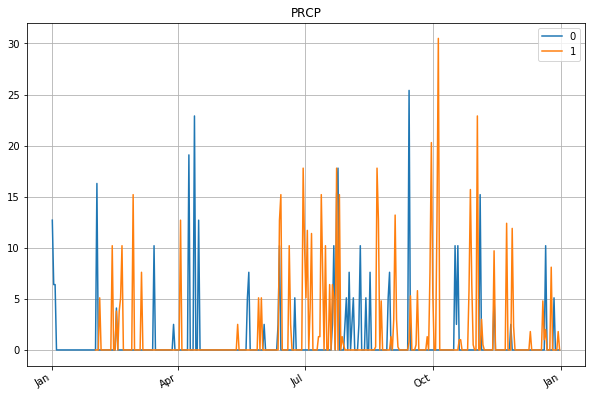

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/bencoden/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


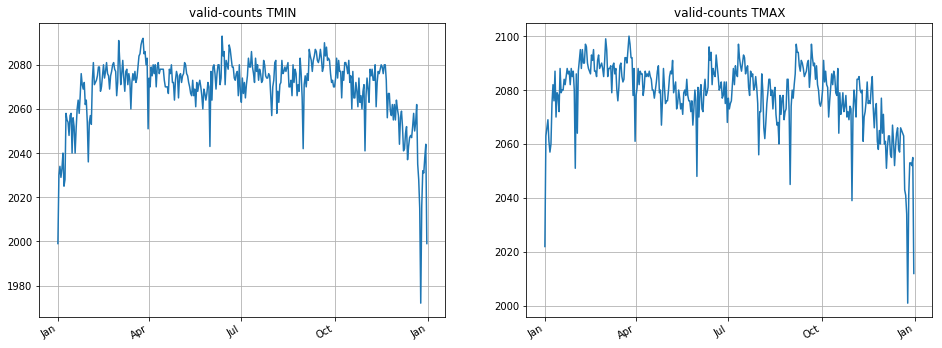

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

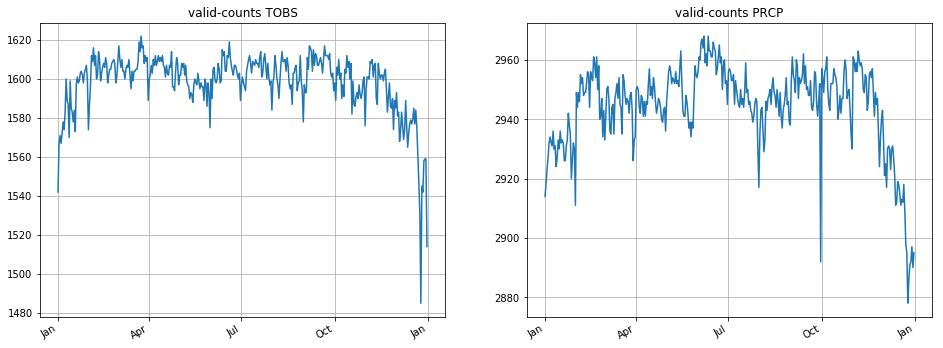

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

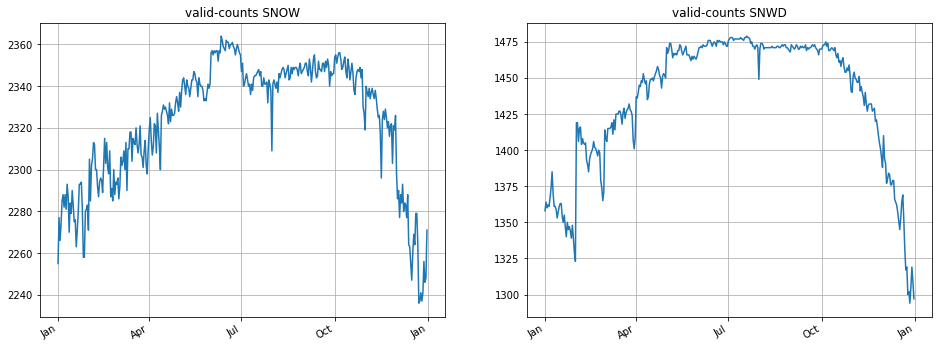

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([(mean-std)/10,mean/10,(mean+std)/10]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

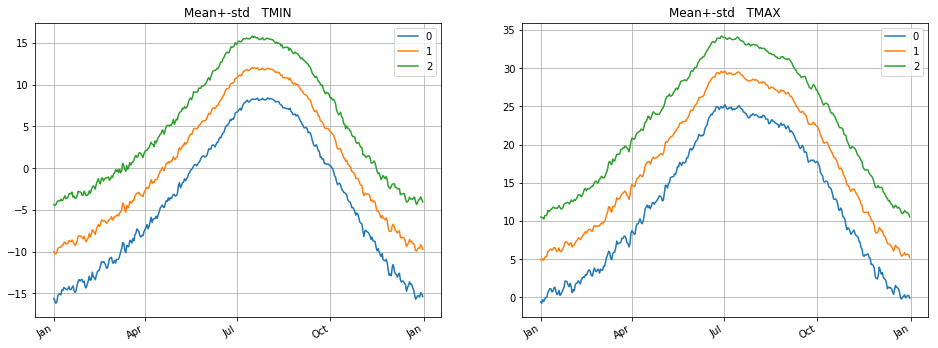

In [9]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

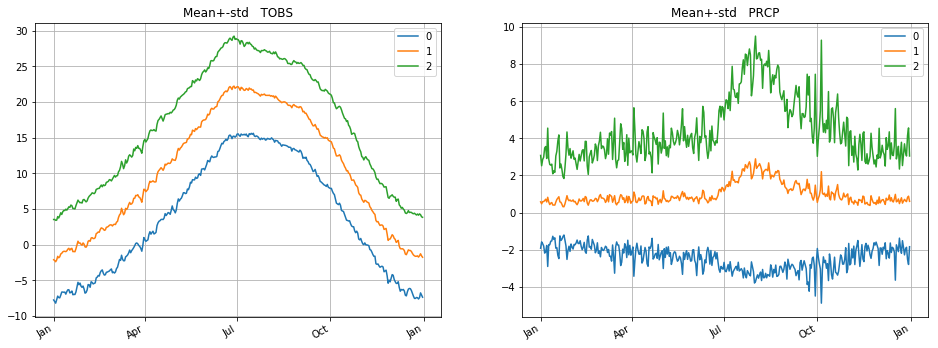

In [10]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

In [11]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

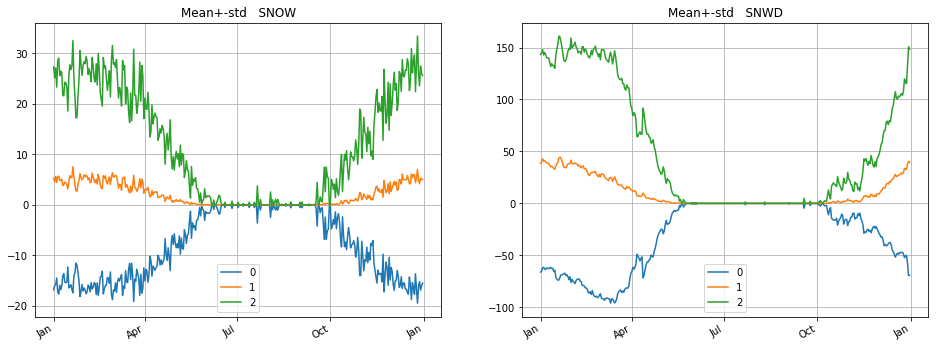

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

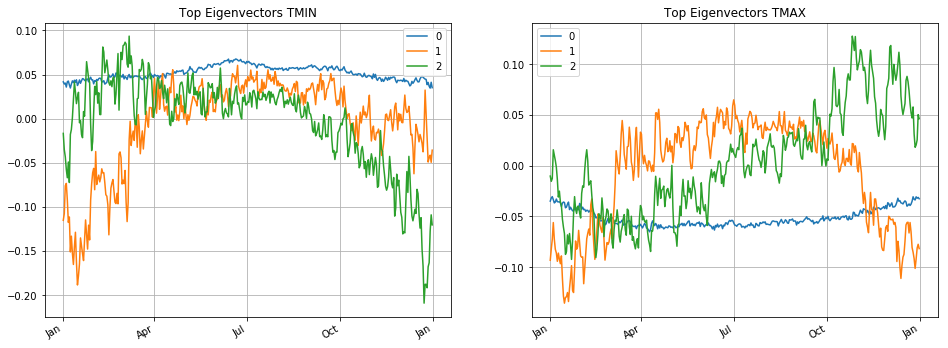

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

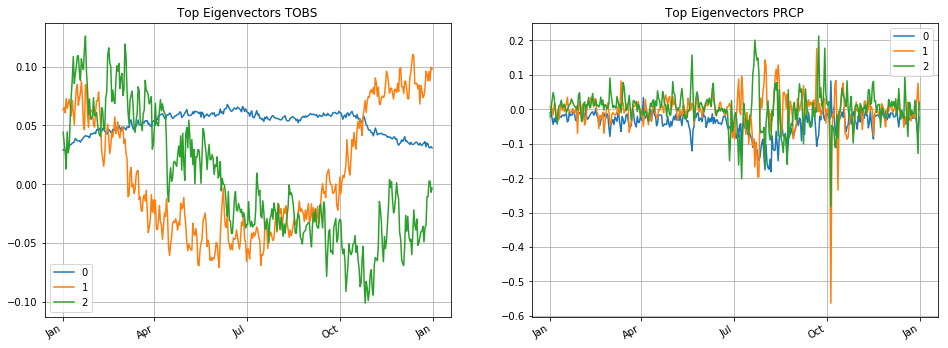

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

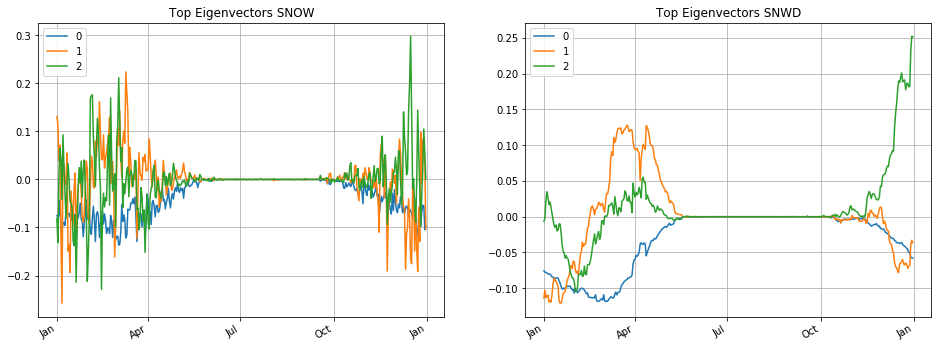

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [17]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

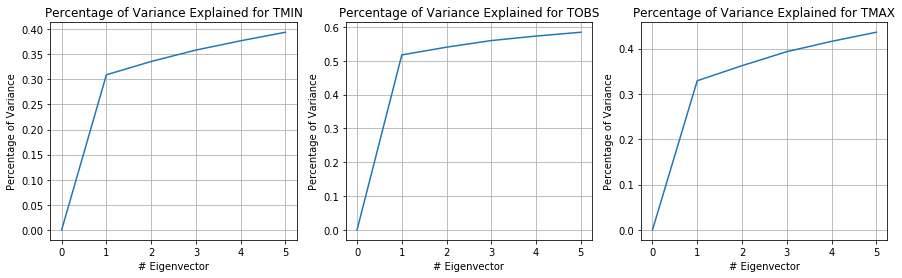

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

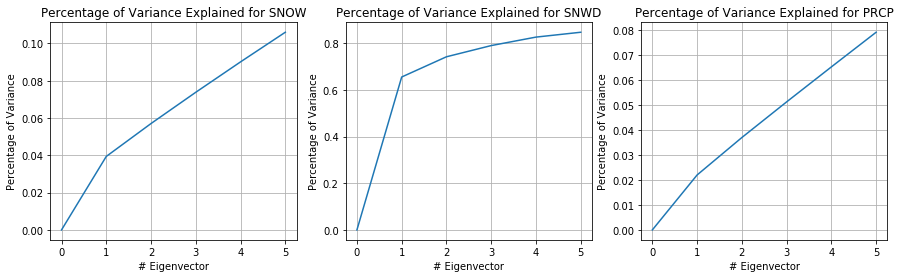

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [20]:
#sc.stop()

In [ ]:
##Additional Analysis

In [239]:
sqlContext.registerDataFrameAsTable(df,'weather_2')
Query_2="SELECT * FROM weather_2\n\tWHERE measurement='%s'"%('TMAX')
print Query_2
df1_2 = sqlContext.sql(Query_2)
print df1_2.count(),'rows'
df1_2.show(2)
rows_2=df1_2.rdd.map(lambda row_2:unpackArray(row_2['vector'],np.float16)).collect()
T_2=np.vstack(rows_2)
T_2=T_2/10.  # scaling to make the temperature be in centingrates
shape(T_2)

SELECT * FROM weather_2
	WHERE measurement='TMAX'
2124 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|     6|[40 56 30 54 40 5...|1910.0|SSSSBBBB|
|   2449.1| 36.0333|-105.8167|       TMAX|USC00299113|    21|[80 C9 30 D4 00 4...|1911.0|SSSSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(2124, 365)

In [240]:
collected_df1_2 = df1_2.collect()
TMAX_df = pd.DataFrame(collected_df1_2)
TMAX_df.head()

0        1         2     3            4   5  \
0  2449.1  36.0333 -105.8167  TMAX  USC00299113   6   
1  2449.1  36.0333 -105.8167  TMAX  USC00299113  21   
2  2449.1  36.0333 -105.8167  TMAX  USC00299113   2   
3  2449.1  36.0333 -105.8167  TMAX  USC00299113   5   
4  2449.1  36.0333 -105.8167  TMAX  USC00299113   0   

                                                   6       7         8  
0  [64, 86, 48, 84, 64, 82, 128, 201, 48, 213, 14...  1910.0  SSSSBBBB  
1  [128, 201, 48, 212, 0, 79, 128, 73, 128, 81, 6...  1911.0  SSSSBBBB  
2  [224, 208, 128, 201, 224, 208, 128, 201, 128, ...  1912.0  SSSSBBBB  
3  [128, 201, 0, 198, 48, 84, 64, 82, 128, 201, 0...  1913.0  SSSSBBBB  
4  [128, 205, 64, 204, 0, 70, 32, 80, 48, 85, 64,...  1914.0  SSSSBBBB

In [241]:
#vector_headers = []
#for i in xrange(365):
#    vector_headers.append(datetime(1959,1,1)+timedelta(days=i))
#    i +=1
#vector_headers

days_index=pd.date_range('January 1, 2001', periods=365,freq='D')
days=list(days_index)
headers = ['elevation','latitude','longitude','measurement','station','undefs','vector','year','strng']+days

vectors_df = pd.DataFrame(T_2)
vectors_df

0          1          2          3          4          5    \
0     10.000000   6.699219   5.000000  -1.099609  -8.296875  -8.898438   
1     -1.099609  -6.699219   2.800781   1.099609   4.398438   5.000000   
2     -3.900391  -1.099609  -3.900391  -1.099609   4.398438  -1.099609   
3     -1.099609  -0.600098   6.699219   5.000000  -1.099609        NaN   
4     -2.199219  -1.700195   0.600098   3.300781   8.296875  10.000000   
5     10.601562  11.703125   6.699219   3.300781  -0.600098  -1.099609   
6     -1.099609   6.101562   8.898438   8.898438   5.000000  -1.099609   
7      2.800781   1.099609   2.199219  -4.398438   3.900391   8.898438   
8     10.000000  11.101562  10.601562  10.000000   3.900391   2.199219   
9     -2.199219  -9.398438  -4.398438   1.099609   0.600098   3.900391   
10     5.000000   6.101562   9.398438   0.000000   2.800781   1.700195   
11     0.000000   0.600098   4.398438  11.101562   6.699219   4.398438   
12     8.296875   7.800781   5.601562        NaN        NaN        NaN   
13     2.199219   0.600098   4.398438   5.601562   3.900391   5.000000   
14     1.700195   0.000000  -1.099609   1.700195   2.199219   7.199219   
15     1.099609   2.199219   5.601562   5.000000   2.800781   3.300781   
16     2.199219   1.099609  -0.600098   1.700195  -0.600098   3.300781   
17     8.296875  13.296875  11.101562  13.296875  14.398438  12.796875   
18     3.900391   8.296875   8.296875  10.000000   7.199219   8.296875   
19     1.099609   3.300781   1.099609   1.099609  -1.099609   7.199219   
20     2.800781   3.300781   8.296875   6.699219   7.199219   3.900391   
21     2.199219   2.199219   1.099609   2.800781   5.000000   3.900391   
22     8.296875   6.699219   4.398438   2.199219   0.600098  -0.600098   
23     8.898438  10.000000  12.203125  12.796875  10.000000  10.000000   
24    11.101562  12.203125   5.000000   4.398438   3.300781   0.600098   
25    -2.199219  -7.199219  -4.398438   1.099609   3.300781   2.800781   
26     5.000000   1.700195   1.099609  -2.800781  -2.800781  -2.800781   
27     8.296875  10.000000   3.900391  -1.099609   4.398438   2.800781   
28    12.796875  12.796875  11.703125  10.601562  11.703125  10.601562   
29    10.000000   9.398438   8.898438   8.898438  13.296875  10.000000   
...         ...        ...        ...        ...        ...        ...   
2094   1.099609   2.199219   6.101562   6.101562   6.101562   7.800781   
2095  11.101562  10.000000   8.296875  10.000000  11.101562   8.898438   
2096   7.199219   8.296875   4.398438   2.800781   0.600098   5.000000   
2097   7.800781   8.296875   5.601562   7.199219  11.703125   6.101562   
2098   2.800781   5.601562  -0.600098   8.898438   7.199219  11.703125   
2099  10.000000  12.203125   6.699219   3.900391   8.898438   7.199219   
2100  11.101562  11.101562  14.398438  13.898438  20.000000   5.601562   
2101   7.800781   7.199219   9.398438   3.300781   3.900391   6.699219   
2102   6.101562   2.199219   6.101562  12.203125  12.796875   8.898438   
2103  17.796875  17.203125  17.796875   8.296875   2.800781  -0.600098   
2104  10.000000   9.398438  13.296875  11.101562  10.000000   6.101562   
2105  11.101562  11.703125   5.000000   8.898438  13.898438  14.398438   
2106  10.601562   8.296875   9.398438  13.296875  15.601562  13.898438   
2107   6.101562  12.796875  14.398438  14.398438   3.300781   3.300781   
2108  11.101562  15.000000   7.199219  10.000000  10.000000   6.699219   
2109  12.796875  12.796875  16.093750  17.203125  15.000000  12.203125   
2110  -1.700195  -1.099609   0.600098   1.700195   6.699219   7.199219   
2111   5.000000   1.700195   3.300781   8.296875  12.203125  13.898438   
2112  13.296875  13.898438  13.898438   5.601562   3.900391   4.398438   
2113   9.398438  10.601562   6.101562   7.800781   7.199219  10.000000   
2114  -2.800781   1.099609   5.601562   6.101562   5.000000   6.101562   
2115  11.101562  10.000000  11.101562  12.796875  11.703125  13.296875   
2116   1.700195 

In [242]:
Data = pd.concat([TMAX_df, vectors_df], axis=1)
Data.columns = headers
Data.drop('vector', axis=1, inplace=True)
Data.head()

elevation  latitude  longitude measurement      station  undefs    year  \
0     2449.1   36.0333  -105.8167        TMAX  USC00299113       6  1910.0   
1     2449.1   36.0333  -105.8167        TMAX  USC00299113      21  1911.0   
2     2449.1   36.0333  -105.8167        TMAX  USC00299113       2  1912.0   
3     2449.1   36.0333  -105.8167        TMAX  USC00299113       5  1913.0   
4     2449.1   36.0333  -105.8167        TMAX  USC00299113       0  1914.0   

      strng  2001-01-01 00:00:00  2001-01-02 00:00:00         ...           \
0  SSSSBBBB            10.000000             6.699219         ...            
1  SSSSBBBB            -1.099609            -6.699219         ...            
2  SSSSBBBB            -3.900391            -1.099609         ...            
3  SSSSBBBB            -1.099609            -0.600098         ...            
4  SSSSBBBB            -2.199219            -1.700195         ...            

   2001-12-22 00:00:00  2001-12-23 00:00:00  2001-12-24 00:00:00  \
0             1.099609             1.099609             4.398438   
1            -6.101562            -6.101562            -5.601562   
2             0.600098             3.900391             4.398438   
3            -8.296875            -6.101562            -5.000000   
4             4.398438             6.101562             0.600098   

   2001-12-25 00:00:00  2001-12-26 00:00:00  2001-12-27 00:00:00  \
0             2.800781             2.199219             1.700195   
1            -2.199219           -10.601562            -1.099609   
2             1.700195             5.000000             3.900391   
3            -4.398438             3.300781             2.199219   
4             1.700195             2.199219             6.101562   

   2001-12-28 00:00:00  2001-12-29 00:00:00  2001-12-30 00:00:00  \
0             1.099609            -1.099609            -0.600098   
1            -1.099609            -1.099609            -5.000000   
2             9.398438             5.000000             1.700195   
3             3.900391            -2.800781            -2.199219   
4            -0.600098            -2.199219            -2.199219   

   2001-12-31 00:00:00  
0                  NaN  
1            -1.099609  
2             4.398438  
3             4.398438  
4             5.601562  

[5 rows x 373 columns]

In [336]:
len(Data.groupby('station')['station'].count())

92

In [243]:
G=Data.loc[:,days]
G[G<-40]=np.nan
G[G>50]=np.nan
Data.loc[:,days]=G
G=G.transpose()

In [244]:
G

0          1          2          3          4          5     \
2001-01-01  10.000000  -1.099609  -3.900391  -1.099609  -2.199219  10.601562   
2001-01-02   6.699219  -6.699219  -1.099609  -0.600098  -1.700195  11.703125   
2001-01-03   5.000000   2.800781  -3.900391   6.699219   0.600098   6.699219   
2001-01-04  -1.099609   1.099609  -1.099609   5.000000   3.300781   3.300781   
2001-01-05  -8.296875   4.398438   4.398438  -1.099609   8.296875  -0.600098   
2001-01-06  -8.898438   5.000000  -1.099609        NaN  10.000000  -1.099609   
2001-01-07  -3.900391   3.900391   0.000000        NaN  15.601562  -4.398438   
2001-01-08   0.000000   6.699219  -1.099609   1.700195   6.101562   0.600098   
2001-01-09   2.199219   7.199219   5.000000   1.099609   0.600098  -1.099609   
2001-01-10   6.699219        NaN   6.101562  -2.800781   8.296875  -2.199219   
2001-01-11   5.000000   4.398438  -1.700195  -5.000000  12.203125   4.398438   
2001-01-12   8.296875   4.398438  -2.800781  -1.099609  16.093750   5.000000   
2001-01-13   1.700195   5.000000   1.700195   4.398438   8.898438   1.700195   
2001-01-14   4.398438  10.000000   4.398438   3.300781  15.000000   5.601562   
2001-01-15   7.199219   8.898438   6.101562   5.000000  11.703125   2.199219   
2001-01-16   2.800781   8.296875   6.699219   4.398438  10.000000  -6.699219   
2001-01-17   2.199219   6.101562   2.199219   0.000000   4.398438  -2.199219   
2001-01-18  -0.600098   6.699219  -0.600098   6.699219   7.199219  -1.099609   
2001-01-19   4.398438   3.900391   2.800781   5.000000   8.296875   0.000000   
2001-01-20   6.101562  11.101562   5.000000   0.000000   6.101562   5.601562   
2001-01-21   7.800781  10.601562   8.898438   4.398438   4.398438   3.900391   
2001-01-22  10.000000   5.000000   5.000000  -1.099609   4.398438  -2.800781   
2001-01-23  10.000000   4.398438  10.000000   1.700195  10.000000  -5.601562   
2001-01-24        NaN   7.199219   8.898438  -0.600098  11.703125  -1.099609   
2001-01-25   7.800781   6.699219  10.000000   4.398438   8.898438   2.800781   
2001-01-26   4.398438   8.296875   8.898438   3.900391   7.800781   0.600098   
2001-01-27   3.900391   7.800781   1.700195   5.000000   4.398438   1.099609   
2001-01-28   4.398438   7.800781   0.000000   7.199219   7.199219   7.800781   
2001-01-29   5.000000   6.699219   3.900391   8.898438   5.601562   5.000000   
2001-01-30   6.101562   5.601562   7.800781   3.900391   6.101562   2.800781   
...               ...        ...        ...        ...        ...        ...   
2001-12-02  13.898438   4.398438  -2.199219   7.800781   1.700195   8.296875   
2001-12-03  13.898438  10.601562   3.900391   2.199219   5.000000   9.398438   
2001-12-04  14.398438  10.601562   3.900391   1.700195   4.398438  11.101562   
2001-12-05   5.000000   7.199219  -3.300781   2.800781   3.300781   3.900391   
2001-12-06   6.699219   4.398438  -5.601562  -1.099609   1.099609  10.601562   
2001-12-07   8.296875   5.601562   3.300781   5.000000  -1.099609  10.601562   
2001-12-08   8.898438   4.398438  -1.700195  10.601562   0.000000  11.101562   
2001-12-09   9.398438   4.398438   0.000000        NaN  -2.800781  10.601562   
2001-12-10  12.796875   0.600098   1.700195  14.398438  -3.900391   3.300781   
2001-12-11  12.203125  -1.099609   3.300781   1.700195  -3.300781   5.601562   
2001-12-12   9.398438  -5.000000   5.601562   0.600098  -3.300781   4.398438   
2001-12-13   8.296875  -5.601562   7.800781   0.000000  -2.199219  10.000000   
2001-12-14   1.099609  -5.000000   8.296875  10.000000  -1.700195  10.000000   
2001-12-15   5.000000  -1.099609   7.800781   1.700195   0.600098   6.101562   
2001-12-16   6.699219   0.600098   0.600098   0.000000  -4.398438  -2.199219   
2001-12-17   8.296875   1.700195  -2.800781   6.699219   1.700195  -0.600098   
2001-12-18   8.898438   0.600098   2.199219   5.000000   0.000000  -2.199219   
2001-12-19   4.398438  -5.000000   2.800781   3.900391   1.700195  -2.199219   
2001-12-20   3.90

(775260,) <class 'pandas.core.series.Series'>
-11.102 42.812


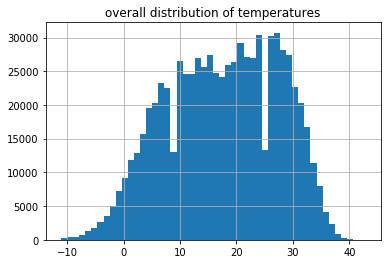

In [245]:
tmp=G.ix[:,:].unstack()
print shape(tmp), type(tmp)
tmp.hist(bins=50);
title('overall distribution of temperatures')
print tmp.min(),tmp.max()

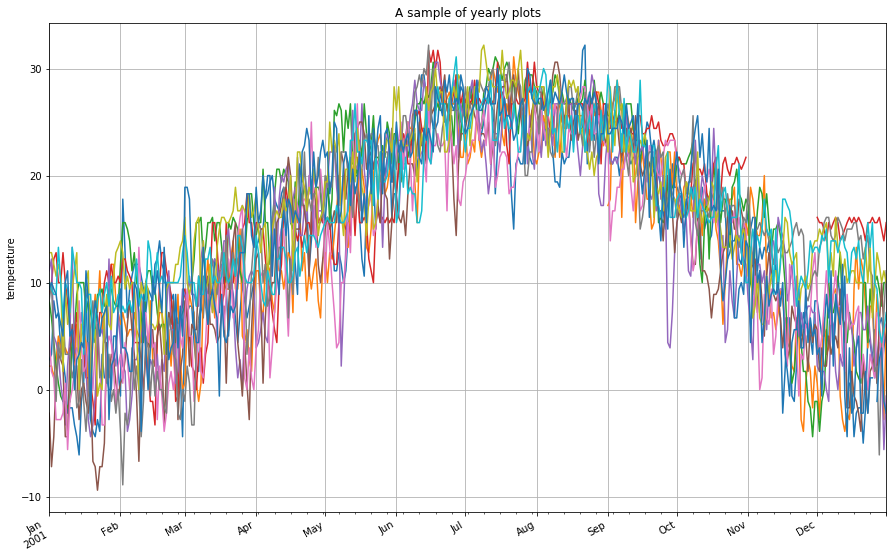

In [246]:
def YearlyPlots(T,ttl='',size=(15,10)):
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    T.set_index(days_index)
    T.plot(legend=False,figsize=size)
    gcf().autofmt_xdate()
    ylabel('temperature')
    grid()
    title(ttl)
YearlyPlots(Data.ix[20:30,days].transpose(),ttl='A sample of yearly plots')

In [247]:
from numpy import mean, std
def Compute_mean_std(Din):
    matrix=Din.loc[:,days]
    Din['Mean']=mean(matrix, axis=1).values 
    Din['Std']=std(matrix, axis=1).values
    return Din

if 'measurement' in Data.columns:
    Data=Data.drop('measurement',axis=1)  
Dout=Compute_mean_std(Data)
Dout=Dout[['station','year','Mean','Std']+days]
Dout.head()

station    year       Mean       Std  2001-01-01 00:00:00  \
0  USC00299113  1910.0  16.296875  8.906250            10.000000   
1  USC00299113  1911.0  13.195312  9.085938            -1.099609   
2  USC00299113  1912.0  12.960938  8.843750            -3.900391   
3  USC00299113  1913.0  13.531250  9.367188            -1.099609   
4  USC00299113  1914.0  13.968750  8.054688            -2.199219   

   2001-01-02 00:00:00  2001-01-03 00:00:00  2001-01-04 00:00:00  \
0             6.699219             5.000000            -1.099609   
1            -6.699219             2.800781             1.099609   
2            -1.099609            -3.900391            -1.099609   
3            -0.600098             6.699219             5.000000   
4            -1.700195             0.600098             3.300781   

   2001-01-05 00:00:00  2001-01-06 00:00:00         ...           \
0            -8.296875            -8.898438         ...            
1             4.398438             5.000000         ...            
2             4.398438            -1.099609         ...            
3            -1.099609                  NaN         ...            
4             8.296875            10.000000         ...            

   2001-12-22 00:00:00  2001-12-23 00:00:00  2001-12-24 00:00:00  \
0             1.099609             1.099609             4.398438   
1            -6.101562            -6.101562            -5.601562   
2             0.600098             3.900391             4.398438   
3            -8.296875            -6.101562            -5.000000   
4             4.398438             6.101562             0.600098   

   2001-12-25 00:00:00  2001-12-26 00:00:00  2001-12-27 00:00:00  \
0             2.800781             2.199219             1.700195   
1            -2.199219           -10.601562            -1.099609   
2             1.700195             5.000000             3.900391   
3            -4.398438             3.300781             2.199219   
4             1.700195             2.199219             6.101562   

   2001-12-28 00:00:00  2001-12-29 00:00:00  2001-12-30 00:00:00  \
0             1.099609            -1.099609            -0.600098   
1            -1.099609            -1.099609            -5.000000   
2             9.398438             5.000000             1.700195   
3             3.900391            -2.800781            -2.199219   
4            -0.600098            -2.199219            -2.199219   

   2001-12-31 00:00:00  
0                  NaN  
1            -1.099609  
2             4.398438  
3             4.398438  
4             5.601562  

[5 rows x 369 columns]

(365, 1)

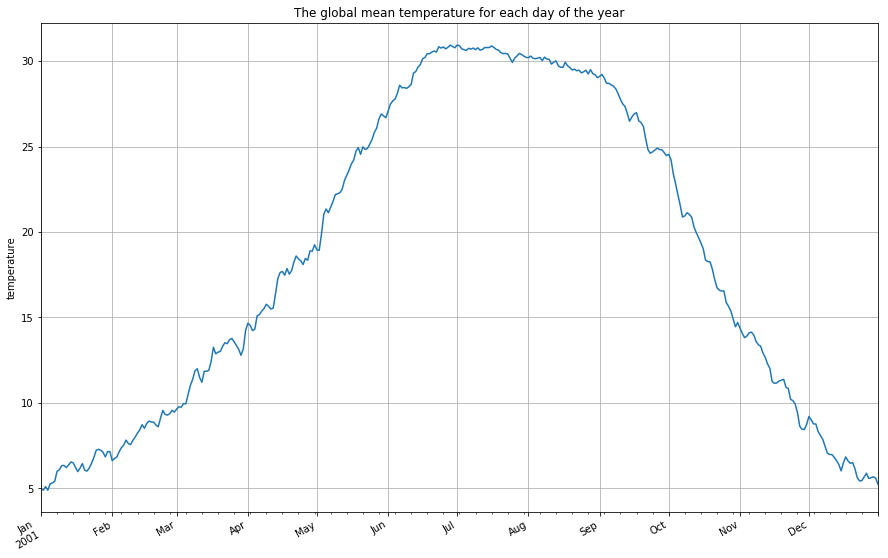

In [248]:
Mean=pd.DataFrame(mean(Dout.ix[:,days], axis=0))
YearlyPlots(Mean,ttl='The global mean temperature for each day of the year')
shape(Mean)

0

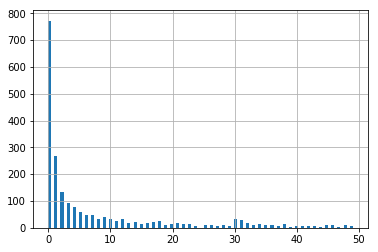

In [249]:
nan_per_row=sum(isnan(Dout.ix[:,1:365]),axis=1)
nan_per_row.hist(bins=100)
sum(nan_per_row>50)

In [250]:
sum(nan_per_row>50)

0

In [251]:
max_nan=50

M=Dout.loc[:,days].transpose()
#M.drop(nan_per_row>0,axis=1,inplace=True)
M=M.ix[:,nan_per_row<max_nan]
Dout=Dout.ix[nan_per_row<max_nan,:]
Dout.index=range(shape(Dout)[0])
(columns,rows)=shape(M)
Mean=mean(M, axis=1).values

print (columns,rows), shape(Mean),shape(M),shape(Dout)
C=np.zeros([columns,columns])   # Sum
N=np.zeros([columns,columns])   # Counter of non-nan entries
Dout.head()

(365, 2124) (365,) (365, 2124) (2124, 369)


station    year       Mean       Std  2001-01-01 00:00:00  \
0  USC00299113  1910.0  16.296875  8.906250            10.000000   
1  USC00299113  1911.0  13.195312  9.085938            -1.099609   
2  USC00299113  1912.0  12.960938  8.843750            -3.900391   
3  USC00299113  1913.0  13.531250  9.367188            -1.099609   
4  USC00299113  1914.0  13.968750  8.054688            -2.199219   

   2001-01-02 00:00:00  2001-01-03 00:00:00  2001-01-04 00:00:00  \
0             6.699219             5.000000            -1.099609   
1            -6.699219             2.800781             1.099609   
2            -1.099609            -3.900391            -1.099609   
3            -0.600098             6.699219             5.000000   
4            -1.700195             0.600098             3.300781   

   2001-01-05 00:00:00  2001-01-06 00:00:00         ...           \
0            -8.296875            -8.898438         ...            
1             4.398438             5.000000         ...            
2             4.398438            -1.099609         ...            
3            -1.099609                  NaN         ...            
4             8.296875            10.000000         ...            

   2001-12-22 00:00:00  2001-12-23 00:00:00  2001-12-24 00:00:00  \
0             1.099609             1.099609             4.398438   
1            -6.101562            -6.101562            -5.601562   
2             0.600098             3.900391             4.398438   
3            -8.296875            -6.101562            -5.000000   
4             4.398438             6.101562             0.600098   

   2001-12-25 00:00:00  2001-12-26 00:00:00  2001-12-27 00:00:00  \
0             2.800781             2.199219             1.700195   
1            -2.199219           -10.601562            -1.099609   
2             1.700195             5.000000             3.900391   
3            -4.398438             3.300781             2.199219   
4             1.700195             2.199219             6.101562   

   2001-12-28 00:00:00  2001-12-29 00:00:00  2001-12-30 00:00:00  \
0             1.099609            -1.099609            -0.600098   
1            -1.099609            -1.099609            -5.000000   
2             9.398438             5.000000             1.700195   
3             3.900391            -2.800781            -2.199219   
4            -0.600098            -2.199219            -2.199219   

   2001-12-31 00:00:00  
0                  NaN  
1            -1.099609  
2             4.398438  
3             4.398438  
4             5.601562  

[5 rows x 369 columns]

In [252]:
#%%time
for i in range(rows):
    if i % 1000==0: 
        print i
    row=M.iloc[:,i]-Mean;
    outer=np.outer(row,row)
    valid=isnan(outer)==False
    C[valid]=C[valid]+outer[valid]  # update C with the valid location in outer
    N[valid]=N[valid]+1
#valid_outer=np.multiply(1-isnan(N),N>0)
cov=np.divide(C,N)

0
1000
2000


In [253]:
shape(cov)

(365, 365)

In [254]:
U,D,V=np.linalg.svd(cov)

In [255]:
shape(U),shape(D),shape(V)

((365, 365), (365,), (365, 365))

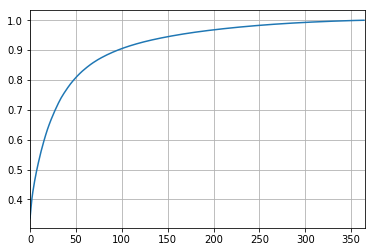

In [256]:
plot(cumsum(D[:])/sum(D))
xlim([0,365])
grid()

(365, 5)


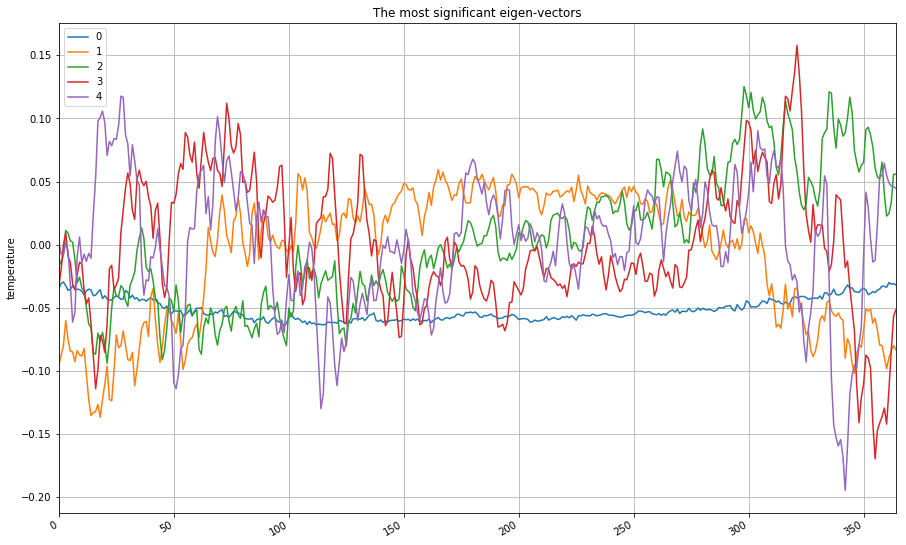

In [257]:
k=5 # number of components to show.
DF_U=pd.DataFrame(U[:,:k])
print shape(DF_U)
YearlyPlots(DF_U,ttl='The most significant eigen-vectors')
legend(range(0,k));

In [258]:
k=5
Eig=np.matrix(U[:,:k])
print 'checking that the norm of the eigenvectors is always 1'
print ['%6.3f,'%np.linalg.norm(U[:,i]) for i in range(k)]
matrix=np.matrix(Dout.ix[:,days])-Mean.transpose()

#replacing nans with zeros
matrix[isnan(matrix)]=0
print shape(Eig),shape(matrix)
Prod=matrix*Eig;
print shape(Prod)

checking that the norm of the eigenvectors is always 1
[' 1.000,', ' 1.000,', ' 1.000,', ' 1.000,', ' 1.000,']
(365, 5) (2124, 365)
(2124, 5)


In [259]:
for i in range(k-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=Dout.index)
    Dout.insert(4,'V'+str(i),Ser)
Dout.head()

station    year       Mean       Std         V0         V1         V2  \
0  USC00299113  1910.0  16.296875  8.906250  27.494150   1.059640   2.016859   
1  USC00299113  1911.0  13.195312  9.085938  74.682015   8.079297 -34.042540   
2  USC00299113  1912.0  12.960938  8.843750  89.188363  -0.799426   2.318725   
3  USC00299113  1913.0  13.531250  9.367188  77.916985   9.548413   7.834533   
4  USC00299113  1914.0  13.968750  8.054688  71.031496 -10.606527 -13.209859   

          V3        V4  2001-01-01 00:00:00         ...           \
0  15.552184  4.646653            10.000000         ...            
1   9.362588  0.804728            -1.099609         ...            
2  -9.705465  3.455295            -3.900391         ...            
3   9.003433 -1.659279            -1.099609         ...            
4   7.734912  8.727427            -2.199219         ...            

   2001-12-22 00:00:00  2001-12-23 00:00:00  2001-12-24 00:00:00  \
0             1.099609             1.099609             4.398438   
1            -6.101562            -6.101562            -5.601562   
2             0.600098             3.900391             4.398438   
3            -8.296875            -6.101562            -5.000000   
4             4.398438             6.101562             0.600098   

   2001-12-25 00:00:00  2001-12-26 00:00:00  2001-12-27 00:00:00  \
0             2.800781             2.199219             1.700195   
1            -2.199219           -10.601562            -1.099609   
2             1.700195             5.000000             3.900391   
3            -4.398438             3.300781             2.199219   
4             1.700195             2.199219             6.101562   

   2001-12-28 00:00:00  2001-12-29 00:00:00  2001-12-30 00:00:00  \
0             1.099609            -1.099609            -0.600098   
1            -1.099609            -1.099609            -5.000000   
2             9.398438             5.000000             1.700195   
3             3.900391            -2.800781            -2.199219   
4            -0.600098            -2.199219            -2.199219   

   2001-12-31 00:00:00  
0                  NaN  
1            -1.099609  
2             4.398438  
3             4.398438  
4             5.601562  

[5 rows x 374 columns]

In [298]:
TMAX_df.columns = ['elevation','latitude','longitude','measurement','station','undefs','vector','year','strng']
Djoined = pd.concat([TMAX_df, Dout], axis=1)

In [299]:
Reduced=Djoined[['latitude','longitude','elevation','Mean','Std','V0','V1','V2','V3','V4']]
Reduced.cov()

latitude  longitude      elevation        Mean         Std  \
latitude    0.093350   0.059375      31.690167   -0.323594   -0.029457   
longitude   0.059375   0.829353      35.193503   -0.402480   -0.248087   
elevation  31.690167  35.193503  123829.671531 -984.321660 -118.197503   
Mean       -0.323594  -0.402480    -984.321660    9.326281    0.843426   
Std        -0.029457  -0.248087    -118.197503    0.843426    0.680791   
V0          6.085280   8.383574   18690.215631 -174.513933  -17.802045   
V1          0.153401  -5.098228    -596.227818   -2.239746   11.955407   
V2          0.176428   0.054890     -97.710029    0.724025    0.310260   
V3          0.010002   0.388927     -60.522799   -0.000667   -1.964613   
V4         -0.017559  -0.160878    -102.650689    0.228188    0.319370   

                     V0          V1          V2          V3          V4  
latitude       6.085280    0.153401    0.176428    0.010002   -0.017559  
longitude      8.383574   -5.098228    0.054890    0.388927   -0.160878  
elevation  18690.215631 -596.227818  -97.710029  -60.522799 -102.650689  
Mean        -174.513933   -2.239746    0.724025   -0.000667    0.228188  
Std          -17.802045   11.955407    0.310260   -1.964613    0.319370  
V0          3300.702171   -3.646654    7.256929   -4.233460   -1.280274  
V1            -3.646654  330.130992    1.137457   -1.125135   -0.272369  
V2             7.256929    1.137457  302.869067    0.053210    0.157989  
V3            -4.233460   -1.125135    0.053210  220.885350    0.543529  
V4            -1.280274   -0.272369    0.157989    0.543529  186.612765

In [300]:
Reduced.corr()

latitude  longitude  elevation      Mean       Std        V0  \
latitude   1.000000   0.213392   0.294752 -0.346809 -0.116851  0.346674   
longitude  0.213392   1.000000   0.109820 -0.144717 -0.330163  0.160235   
elevation  0.294752   0.109820   1.000000 -0.915947 -0.407089  0.924483   
Mean      -0.346809  -0.144717  -0.915947  1.000000  0.334723 -0.994655   
Std       -0.116851  -0.330163  -0.407089  0.334723  1.000000 -0.375543   
V0         0.346674   0.160235   0.924483 -0.994655 -0.375543  1.000000   
V1         0.027633  -0.308110  -0.093252 -0.040365  0.797470 -0.003493   
V2         0.033181   0.003463  -0.015955  0.013623  0.021607  0.007258   
V3         0.002203   0.028735  -0.011572 -0.000015 -0.160209 -0.004958   
V4        -0.004207  -0.012932  -0.021354  0.005470  0.028335 -0.001631   

                 V1        V2        V3        V4  
latitude   0.027633  0.033181  0.002203 -0.004207  
longitude -0.308110  0.003463  0.028735 -0.012932  
elevation -0.093252 -0.015955 -0.011572 -0.021354  
Mean      -0.040365  0.013623 -0.000015  0.005470  
Std        0.797470  0.021607 -0.160209  0.028335  
V0        -0.003493  0.007258 -0.004958 -0.001631  
V1         1.000000  0.003597 -0.004167 -0.001097  
V2         0.003597  1.000000  0.000206  0.000665  
V3        -0.004167  0.000206  1.000000  0.002677  
V4        -0.001097  0.000665  0.002677  1.000000

In [301]:
abs(Reduced.corr())>0.2

latitude longitude elevation   Mean    Std     V0     V1     V2  \
latitude      True      True      True   True  False   True  False  False   
longitude     True      True     False  False   True  False   True  False   
elevation     True     False      True   True   True   True  False  False   
Mean          True     False      True   True   True   True  False  False   
Std          False      True      True   True   True   True   True  False   
V0            True     False      True   True   True   True  False  False   
V1           False      True     False  False   True  False   True  False   
V2           False     False     False  False  False  False  False   True   
V3           False     False     False  False  False  False  False  False   
V4           False     False     False  False  False  False  False  False   

              V3     V4  
latitude   False  False  
longitude  False  False  
elevation  False  False  
Mean       False  False  
Std        False  False  
V0         False  False  
V1         False  False  
V2         False  False  
V3          True  False  
V4         False   True

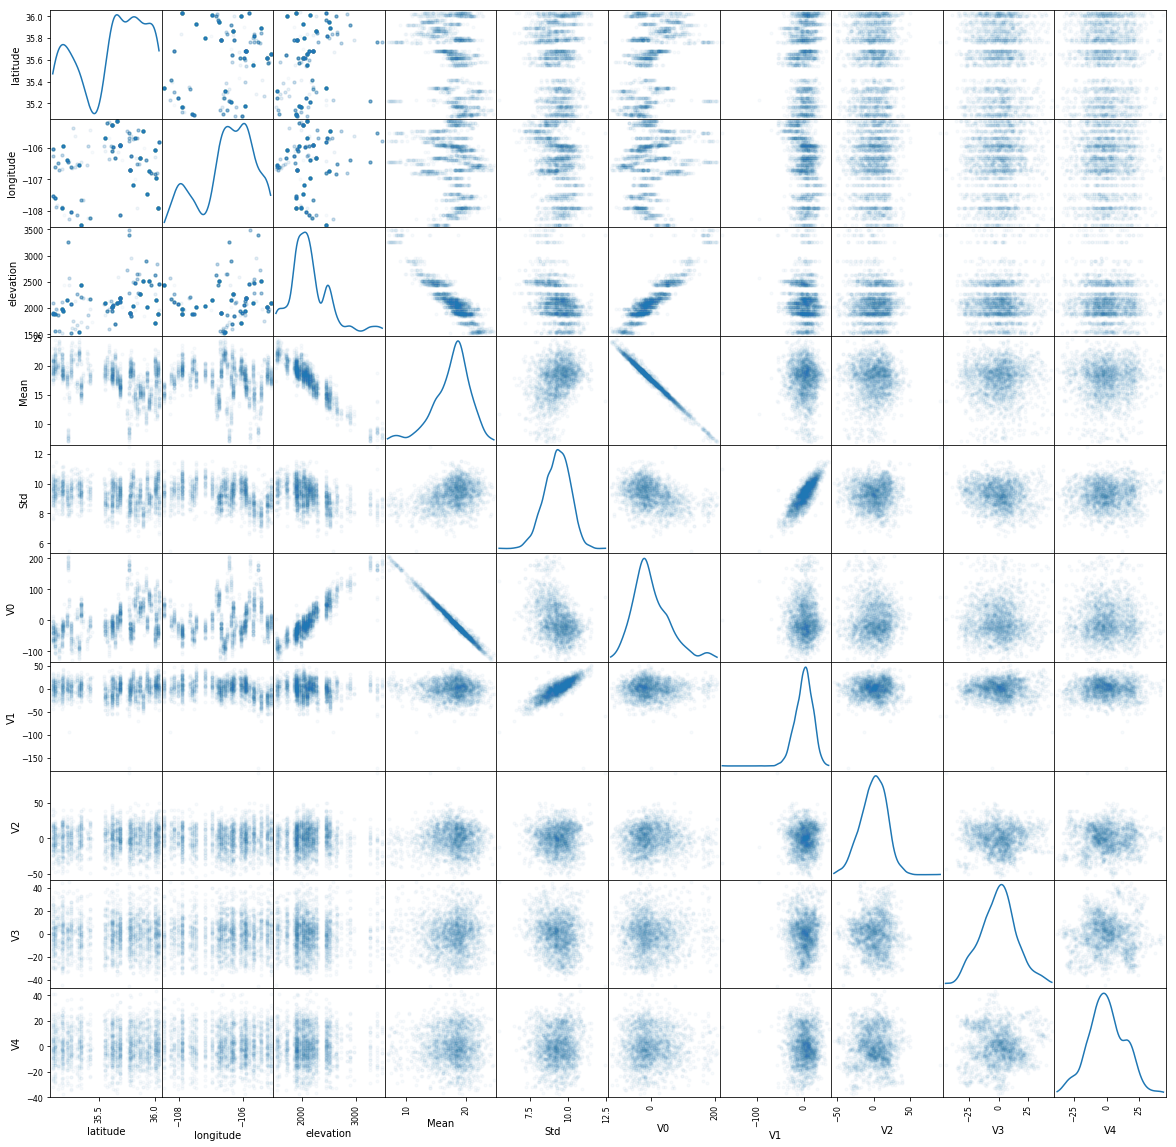

In [327]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(Reduced, alpha=0.03, figsize=(20, 20), diagonal='kde');

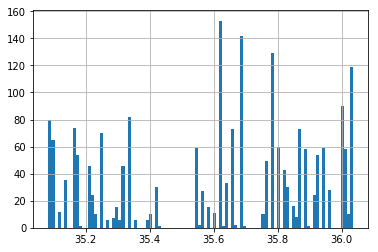

In [328]:
X='latitude'
Djoined.ix[:,X].hist(bins=100);

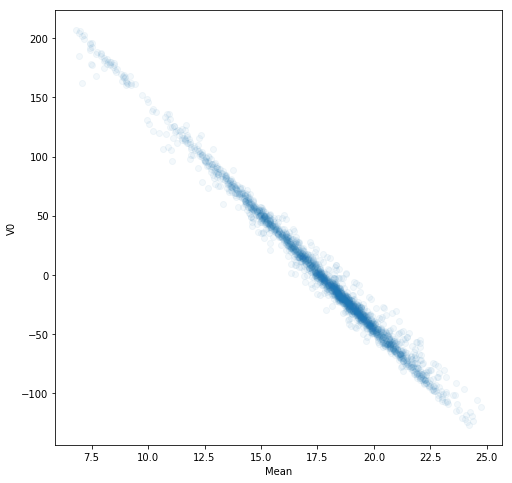

In [338]:
X='Mean';Y='V0'
figure(figsize=(8,8))
scatter(Djoined.loc[:,X],Djoined.loc[:,Y],alpha=0.05)
xlabel(X)
ylabel(Y)

In [330]:
#checking for an anomaly in the elevations of stations
Djoined[['station','elevation']][Djoined['elevation']<-500].head()


Empty DataFrame
Columns: [station, station, elevation]
Index: []

In [333]:
lons=Data['longitude'].values
lats=Data['latitude'].values
station_names=Data['station'].values
ll=len(lons)
#lonmin=-180;lonmax=180;latsmin=-80;latsmax=80;
lonmin=-130;lonmax=-50;latsmin=20;latsmax=50;
select=(lons>lonmin) * (lons<lonmax)*(lats>latsmin)*(lats<latsmax)
print sum(select)
station_names=station_names[select]
lons=lons[select]
lats=lats[select]
print len(lons),len(lats),len(station_names)

2124
2124 2124 2124


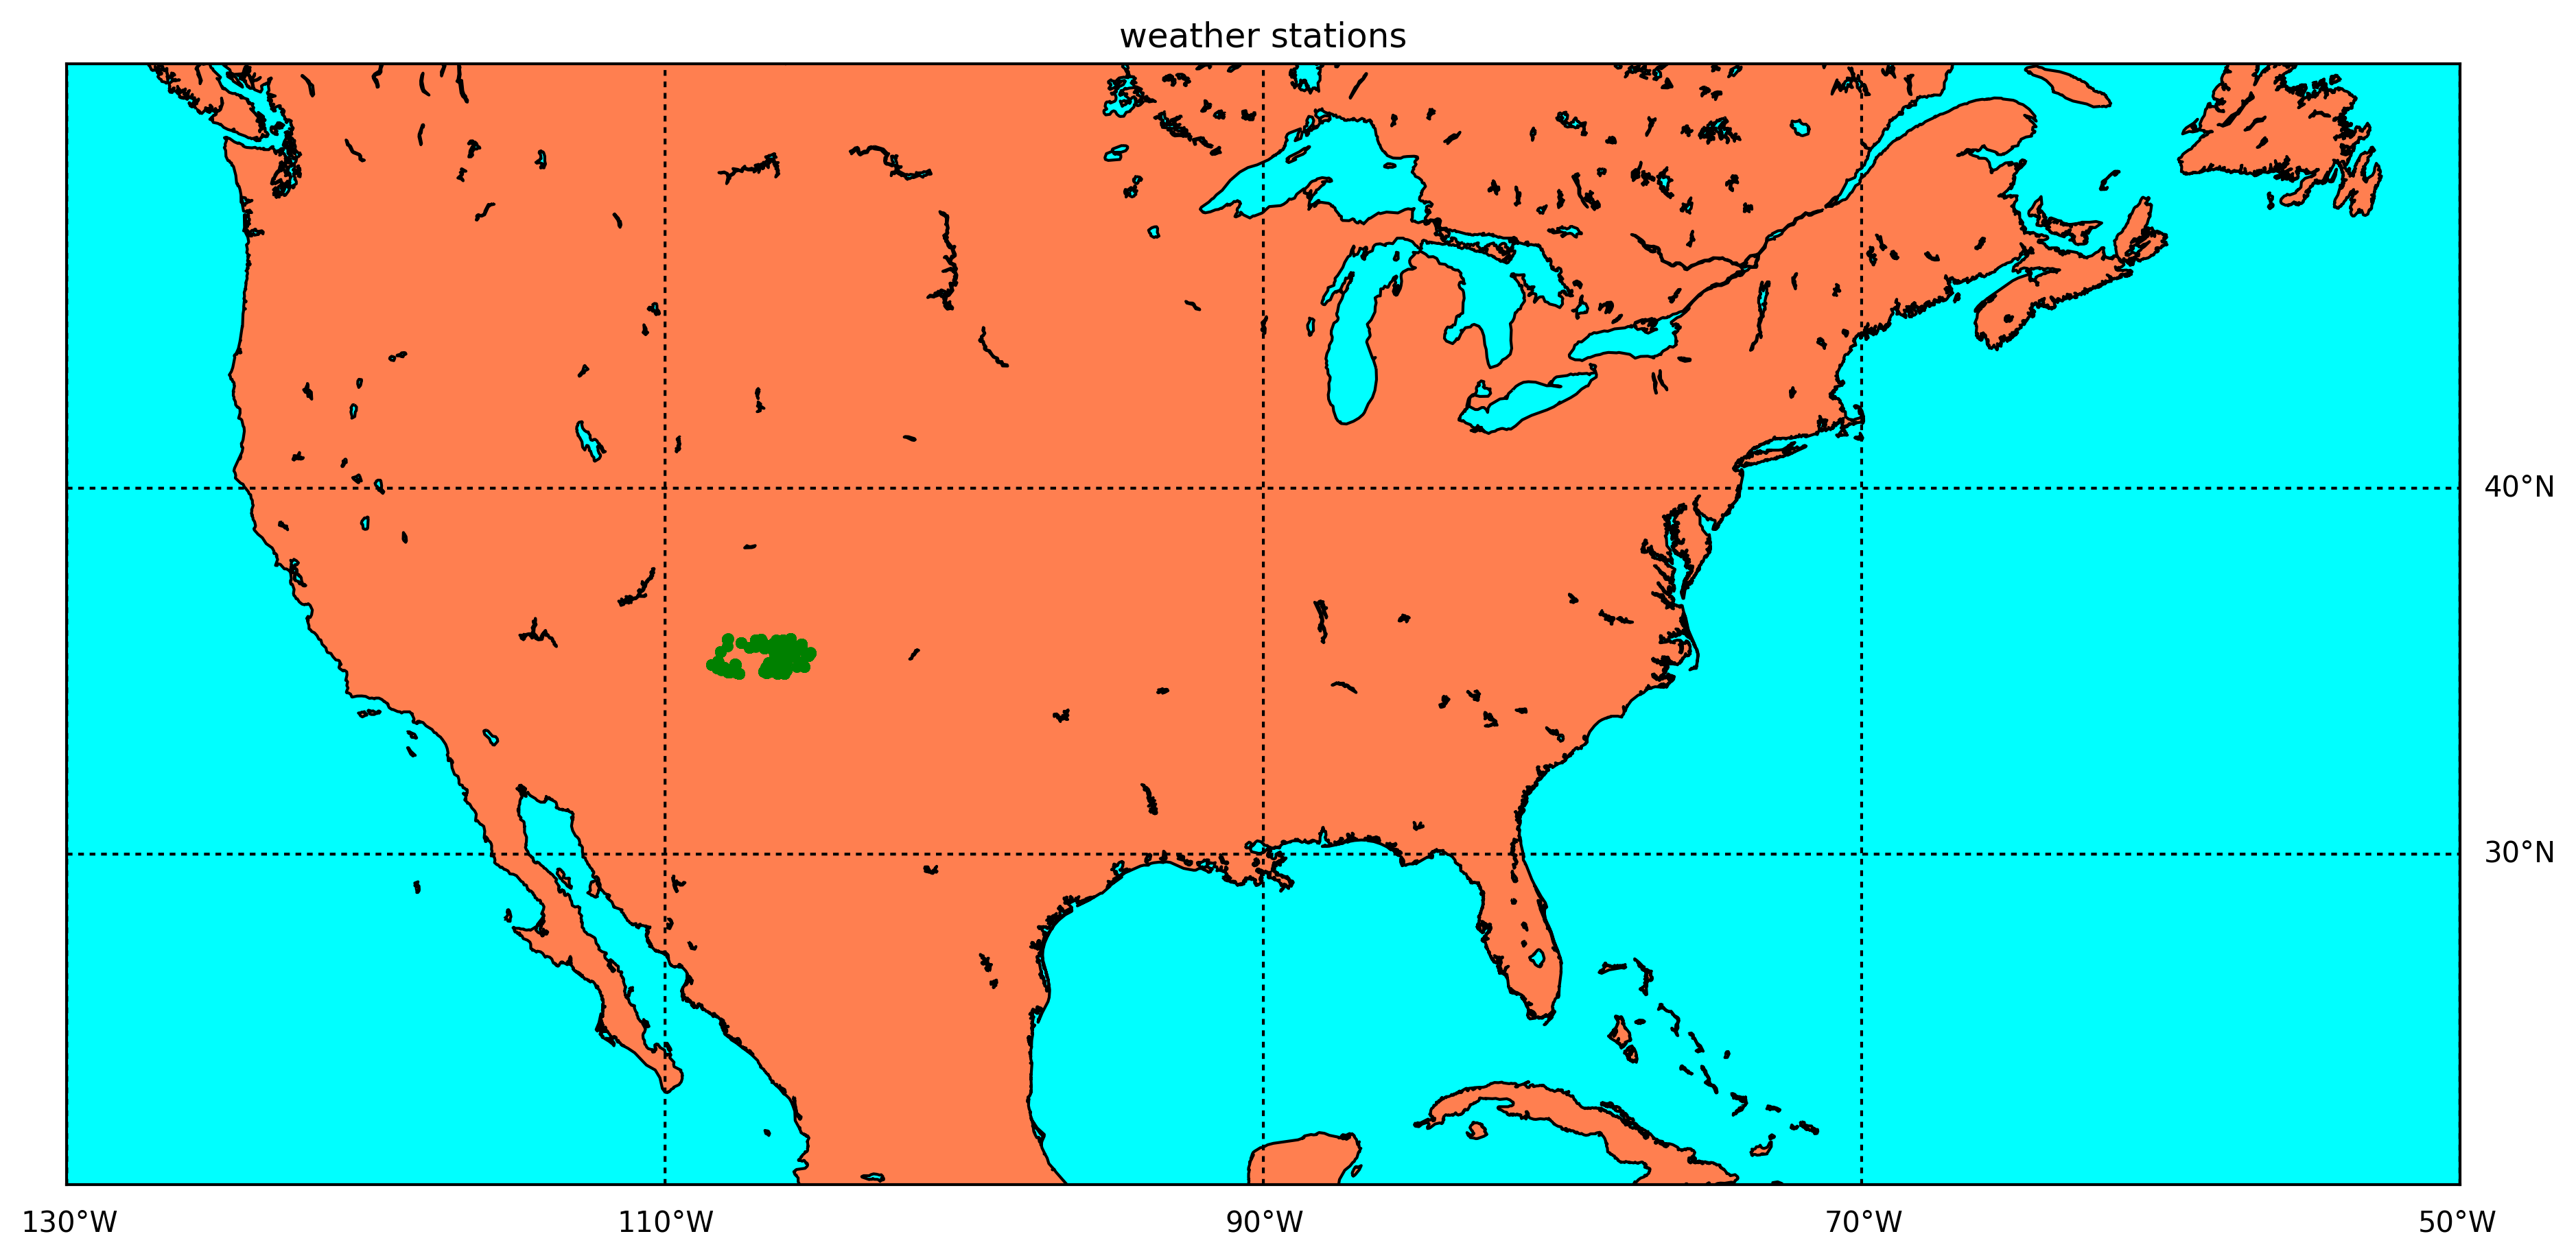

In [334]:
# http://matplotlib.org/basemap/users/merc.html

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'i' means use intermediate resolution coastlines.
plt.figure(figsize=(15,10),dpi=300)
m = Basemap(projection='merc',llcrnrlat=latsmin,urcrnrlat=latsmax,\
            llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=20,resolution='i')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# draw parallels and meridians.
parallels = np.arange(-80,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])

#m.drawparallels(np.arange(-90.,91.,30.))
#m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

# draw map with markers for locations
x, y = m(lons,lats)
m.plot(x,y,'g.')

plt.title('weather stations')
plt.show()



In [305]:
KMean=np.array([Mean])

k=10
Keig=Eig[:,:k]
Kprod=Prod[:,:k]
Recon=pd.DataFrame(Kprod*Keig.transpose() +KMean)
Recon.columns=days_index

In [306]:
print shape(Djoined.ix[i,days])
print shape(Recon.ix[i,days])

shape(Djoined),shape(Recon)

(365,)
(365,)


((2124, 383), (2124, 365))

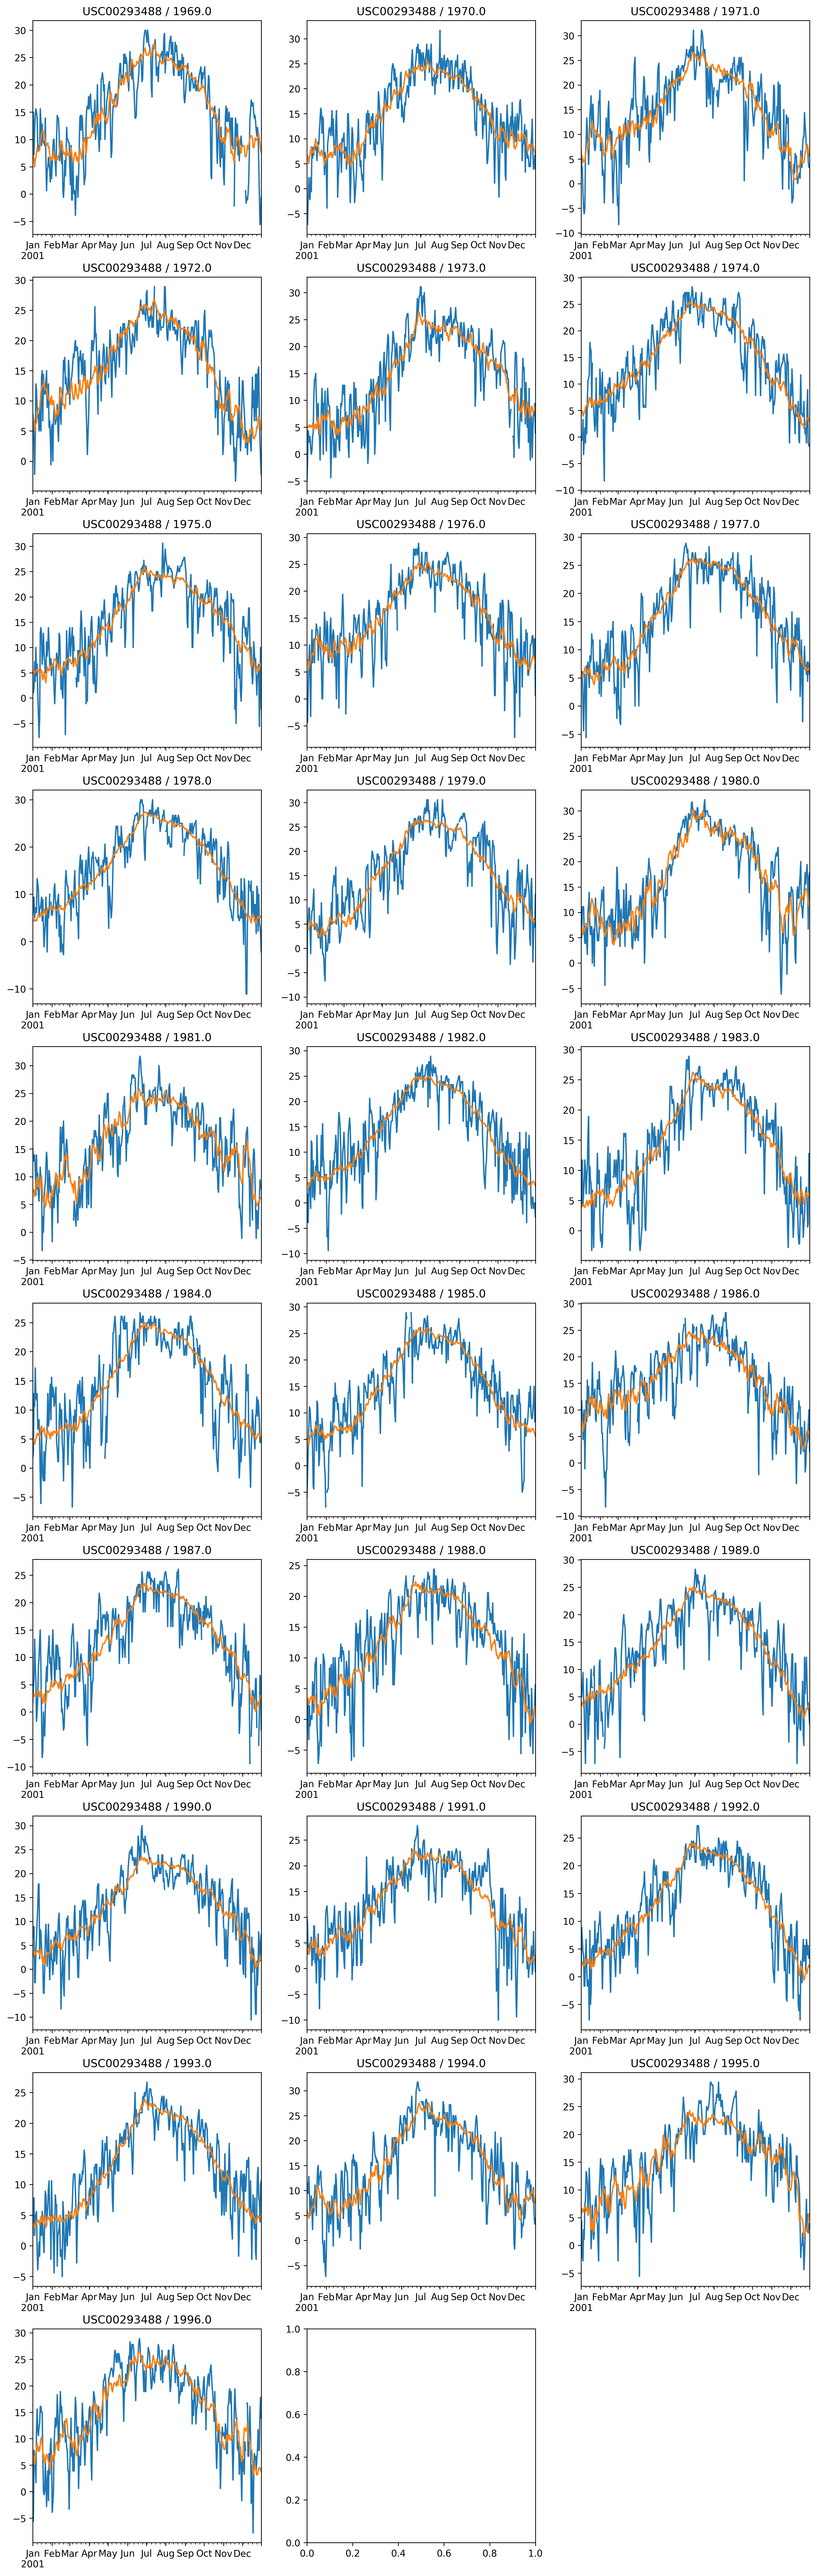

In [337]:
def plot_reconstructions(selection,rows=2,columns=7,size=3):
    plt.figure(figsize=(columns*size,rows*size),dpi=300)
    j=1;
    for i in selection:
        subplot(rows,columns,j); 
        j += 1; 
        if j>=rows*columns: 
            break
        (Djoined.ix[i,18:]).plot()
        (Recon.ix[i,days]).plot()
        title(str(Djoined.ix[i,'station'].values[0])+' / '+str(Djoined.ix[i,'year'].values[0]))
plot_reconstructions(range(1910,1960),rows=10,columns=3,size=5)

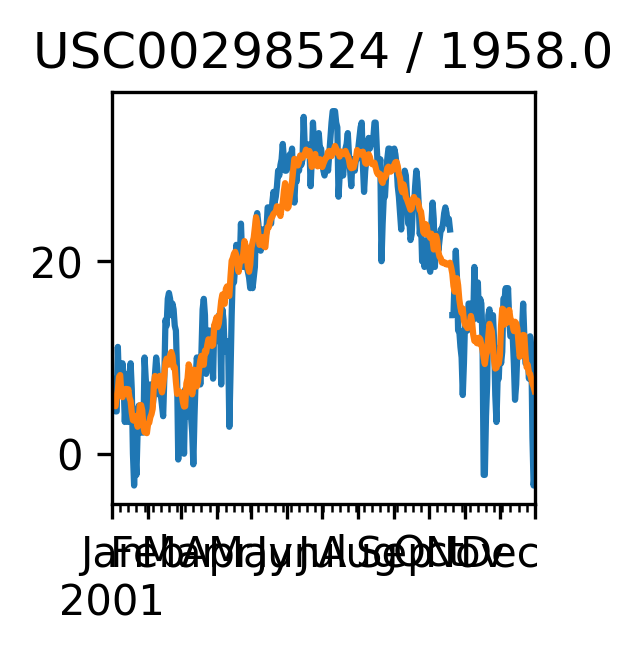

In [342]:
plot_reconstructions([1959],rows=2,columns=2,size=2)

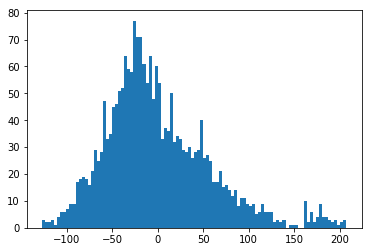

In [325]:
hist(Djoined.ix[:,'V0'],bins=100);

In [326]:
selection= [i for i in range(shape(Djoined)[0]) if Djoined.ix[i,'latitude']<-10]
plot_reconstructions(selection,rows=7,columns=3)
shape(selection)

(0,)